In [1]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.'
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [2]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '300'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
 X_0(\mathbf{p}_\perp,t,T) = \frac{ C_{B_{1S}\rightarrow D^*_a}^{A_4}(\mathbf{p}_\perp,t,T) }{  C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf p_\parallel,t,T)  } \quad/\quad \sqrt{  \frac{ Z_{D_a^*}(\mathbf p_\perp) }{ Z_{D_a^*}(\mathbf p_\parallel) }  }
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_A4_V1_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 13 --------- smr = '1S' -------------------
P5_A4_V1_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_A4_V1_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 13 --------- smr = 'RW' -------------------
P5_A4_V1_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A2_V2_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300


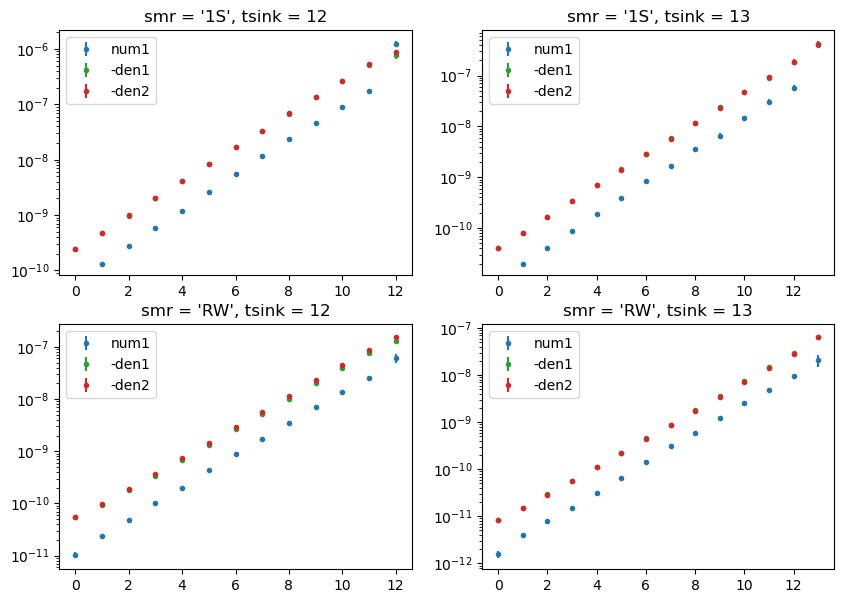

In [3]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1
        corr = RatioFileString('P5_A4_V1_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)        
        
        # Denominator 1
        corr = RatioFileString('P5_A2_V2_',tsink,heavy,smr,qq,light,mom)
        den1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)        
        
        corr = RatioFileString('P5_A3_V3_',tsink,heavy,smr,qq,light,mom)
        den2 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)        
        
        r = num1 / ((den1 + den2))
        data_read[smr][tsink] = r

        v = format(num1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        v = -format(den1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='-den1',color='C2')
        v = -format(den2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='-den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

-------------- tsink = 12 smr = '1S' --------------
[0.061(14) -0.1370(76) -0.1433(72) -0.1464(84) -0.1425(93) -0.158(11)
 -0.167(11) -0.177(12) -0.173(12) -0.172(12) -0.170(12) -0.170(16)
 -0.76(11)]
13
-------------- tsink = 13 smr = '1S' --------------
[0.033(15) -0.122(10) -0.121(11) -0.128(12) -0.136(13) -0.135(14)
 -0.143(15) -0.147(14) -0.151(16) -0.140(18) -0.152(18) -0.166(20)
 -0.156(22) 0.081(68)]
14
-------------- tsink = 12 smr = 'RW' --------------
[-0.094(13) -0.1272(65) -0.1332(70) -0.1421(66) -0.1407(70) -0.1545(79)
 -0.1628(83) -0.1598(94) -0.159(10) -0.161(10) -0.160(10) -0.155(13)
 -0.218(47)]
13
-------------- tsink = 13 smr = 'RW' --------------
[-0.092(16) -0.1302(82) -0.1377(90) -0.1349(93) -0.141(10) -0.148(11)
 -0.162(12) -0.176(13) -0.168(14) -0.173(16) -0.175(14) -0.172(15)
 -0.167(17) -0.164(49)]
14


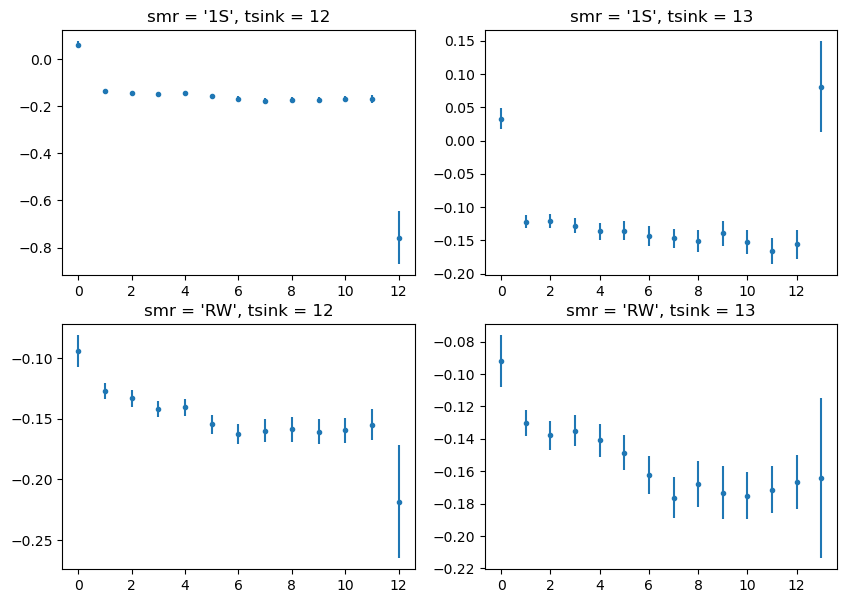

In [4]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))
        print(len(format(data_read[smr][tsink])))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')

## Build correction factor

In the following cell we build the correction factor
$$
\sqrt{\frac{Z_{D^*_a}(\mathbf p_\perp)}{Z_{D^*_a}(\mathbf p _\parallel)}}
$$

In [5]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites, read_config_fit

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'RA1',mom,readfrom=frm)
req

{'E0': 1.179682175085136,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
 'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.1126285207974154,
 'jk': False}

In [6]:
p2 = read_config_fit(f'fit2pt_config_{ens}_Dst_{mom}',path=frm)[-1]
p0 = read_config_fit(f'fit2pt_config_{ens}_Dst_000',  path=frm)[-1]

In [7]:
np.exp(p2['Z.d.Bot'][0].mean)**2 * 2 * p2['dE'][0].mean

0.02595700174869827

Fill the following cells with appropriate values

In [8]:
# req = {
#     'E0': 1.179682175085136,
#     'm0': 1.0809632444217314,
#     'Z0':   {'1S': 4.822281482026914, 'd': 0.04150728444106053},
#     'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
#     'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
# }

In [9]:
factor = {
    '1S': np.sqrt(req['Zpar']['1S']/req['Zbot']['1S']),
    'RW': np.sqrt(req['Zpar']['d' ]/req['Zbot']['d' ]),
}

factor

{'1S': 1.189375238551202, 'RW': 1.1414313208756592}

here we divide the data that we read by the correction factor

In [10]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink][:,:Ta+1] / factor[smr]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

-------------- tsink = 12 smr = '1S' --------------
[0.051(12) -0.1152(64) -0.1205(61) -0.1231(71) -0.1198(78) -0.1330(90)
 -0.1406(91) -0.1486(97) -0.146(10) -0.145(10) -0.143(10) -0.143(13)
 -0.637(95)]
-------------- tsink = 13 smr = '1S' --------------
[0.028(13) -0.1023(87) -0.1017(89) -0.1077(97) -0.115(11) -0.114(12)
 -0.121(12) -0.124(12) -0.127(14) -0.117(15) -0.128(15) -0.139(17)
 -0.131(18)]
-------------- tsink = 12 smr = 'RW' --------------
[-0.083(11) -0.1115(57) -0.1167(61) -0.1245(58) -0.1233(61) -0.1354(69)
 -0.1426(72) -0.1400(82) -0.1390(89) -0.1408(90) -0.1399(89) -0.136(11)
 -0.191(41)]
-------------- tsink = 13 smr = 'RW' --------------
[-0.081(14) -0.1141(72) -0.1206(79) -0.1182(81) -0.1235(87) -0.1301(96)
 -0.142(10) -0.154(11) -0.147(12) -0.152(14) -0.154(13) -0.150(13)
 -0.146(15)]


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) + \frac{1}{4}R_{A_1}(t,T+1)  + \frac{1}{4}R_{A_1}(t+1,T+1) 

In [11]:
barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2 +     data_corr['1S'][Tb]/4 +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4
barR['RW'] = data_corr['RW'][Ta  ]/2 +     data_corr['RW'][Tb]/4 +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4

In [12]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[0.0071(71) -0.1086(57) -0.1126(58) -0.1171(64) -0.1170(73) -0.1251(80)
 -0.1314(82) -0.1370(90) -0.134(10) -0.1338(99) -0.139(10) -0.139(12)
 -0.344(47)]
------------ sm = 'RW' -------------
[-0.0900(77) -0.1144(51) -0.1180(55) -0.1227(54) -0.1250(57) -0.1357(61)
 -0.1454(68) -0.1454(79) -0.1442(83) -0.1467(83) -0.1459(77) -0.1420(89)
 -0.152(20)]


<ErrorbarContainer object of 3 artists>

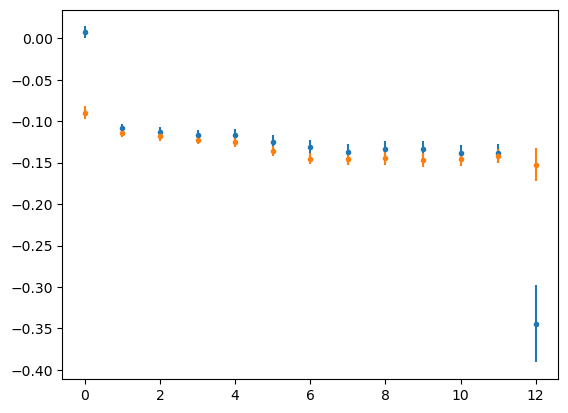

In [13]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.')

# `CUSTOM`

In [14]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [15]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'R0',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [16]:
robj.format()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 {'1S': array([0.014(14), -0.217(11), -0.225(12), -0.234(13), -0.234(15),
         -0.250(16), -0.263(17), -0.274(18), -0.268(20), -0.268(20),
         -0.277(20), -0.278(24), -0.688(94)], dtype=object),
  'RW': array([-0.180(15), -0.229(10), -0.236(11), -0.245(11), -0.250(11),
         -0.271(12), -0.291(14), -0.291(16), -0.288(17), -0.293(17),
         -0.292(15), -0.284(18), -0.305(41)], dtype=object)})

In [17]:
x,rr = robj.format()
r1S = rr['1S']
rRW = rr['RW']

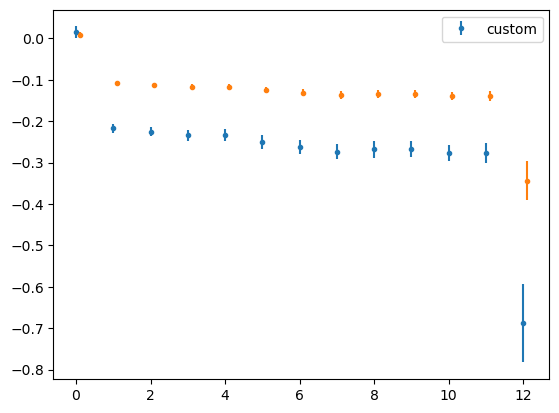

In [18]:
plt.errorbar(x,gv.mean(r1S),gv.sdev(r1S),fmt='.',label='custom')
plt.errorbar(x+0.1,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.legend()

<ErrorbarContainer object of 3 artists>

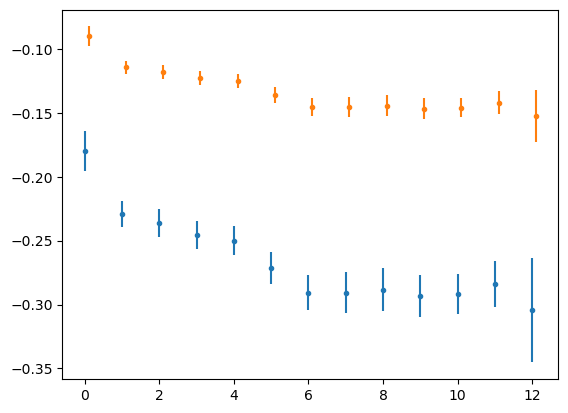

In [19]:
plt.errorbar(x    ,gv.mean(rRW),gv.sdev(rRW),fmt='.')
plt.errorbar(x+0.1,gv.mean(yRW),gv.sdev(yRW),fmt='.')